### Filtering mobile phone spam sms uning Naive Bayes Algorithm

##### Read the dataset and load the libraries

In [1401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import string 
import nltk
import scipy
from scipy.sparse import csr_matrix

sms_raw = pd.read_csv("sms_spam.csv")
sms_raw.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [1402]:
sms_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5559 non-null   object
 1   text    5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [1403]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [1404]:
sms_raw['type'] = encoder.fit_transform(sms_raw['type'])

In [1405]:
sms_raw.head()

,type,text
0,0,Hope you are having a good week. Just checking in
1,0,K..give back my thanks.
2,0,Am also doing in cbe only. But have to pay.
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,1,okmail: Dear Dave this is your final notice to...


### Data preparation – processing text data for analysis

In [1406]:
# missing values
sms_raw.isnull().sum()

type    0
text    0
dtype: int64

In [1407]:
# duplicate value 
sms_raw.duplicated().sum()

404

In [1408]:
sms_raw.head()

,type,text
0,0,Hope you are having a good week. Just checking in
1,0,K..give back my thanks.
2,0,Am also doing in cbe only. But have to pay.
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,1,okmail: Dear Dave this is your final notice to...


### EDA

In [1409]:
sms_raw.type.value_counts()

0    4812
1     747
Name: type, dtype: int64

In [1410]:
round(sms_raw.type.value_counts(normalize=True)*100, 1)

0    86.6
1    13.4
Name: type, dtype: float64

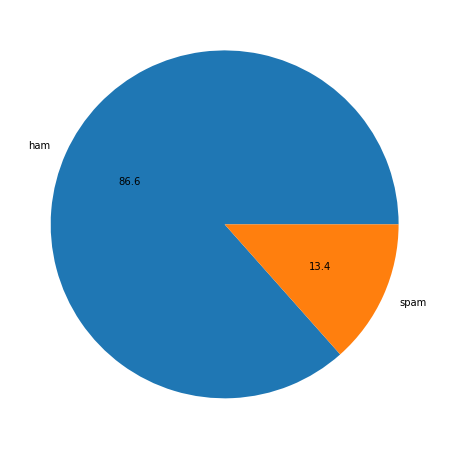

In [1411]:
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(round(sms_raw.type.value_counts()), labels=["ham", "spam"], autopct="%0.1f")
plt.show()

In [1412]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pappu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1413]:
# count number of character per sms
sms_raw['num_characters'] = sms_raw['text'].apply(len) 

In [1414]:
sms_raw.head()

,type,text,num_characters
0,0,Hope you are having a good week. Just checking in,49
1,0,K..give back my thanks.,23
2,0,Am also doing in cbe only. But have to pay.,43
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149
4,1,okmail: Dear Dave this is your final notice to...,161


In [1415]:
# Count number of words per sms
sms_raw['num_words'] = sms_raw['text'].apply(lambda x:len(nltk.word_tokenize(x)))
sms_raw.head()

,type,text,num_characters,num_words
0,0,Hope you are having a good week. Just checking in,49,11
1,0,K..give back my thanks.,23,7
2,0,Am also doing in cbe only. But have to pay.,43,12
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,23
4,1,okmail: Dear Dave this is your final notice to...,161,32


In [1416]:
sms_raw['num_sentences'] = sms_raw['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [1417]:
 sms_raw.head()

,type,text,num_characters,num_words,num_sentences
0,0,Hope you are having a good week. Just checking in,49,11,2
1,0,K..give back my thanks.,23,7,1
2,0,Am also doing in cbe only. But have to pay.,43,12,2
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,23,3
4,1,okmail: Dear Dave this is your final notice to...,161,32,3


In [1418]:
sms_raw[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5559.000000,5559.000000,5559.000000
mean,79.771362,18.404569,2.001259
std,59.102098,13.178332,1.521407
min,2.000000,1.000000,1.000000
25%,35.000000,9.000000,1.000000
50%,61.000000,15.000000,2.000000
75%,121.000000,27.000000,2.000000
max,910.000000,196.000000,38.000000


In [1419]:
sms_raw[sms_raw['type'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4812.000000,4812.000000,4812.000000
mean,70.636534,16.921239,1.840191
std,57.315003,13.303058,1.452219
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,196.000000,38.000000


In [1420]:
sms_raw[sms_raw['type'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.615797,27.959839,3.038822
std,28.877218,6.854364,1.548966
min,13.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


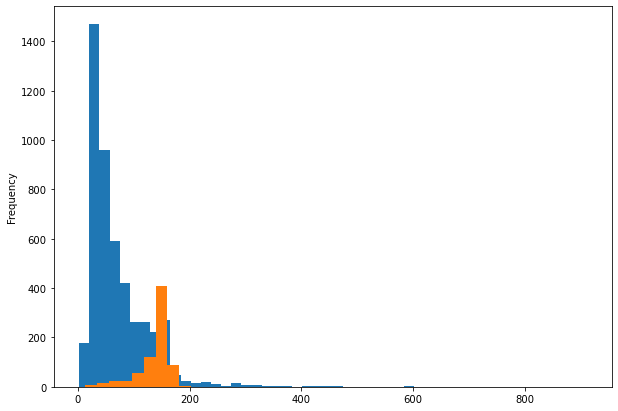

In [1421]:
sms_raw[sms_raw['type'] == 0]['num_characters'].plot.hist(bins=50, figsize=(10,7));
sms_raw[sms_raw['type'] == 1]['num_characters'].plot.hist(bins=10, figsize=(10,7));
ax1.set(title="Histrogram of number of character of both ham and spam");

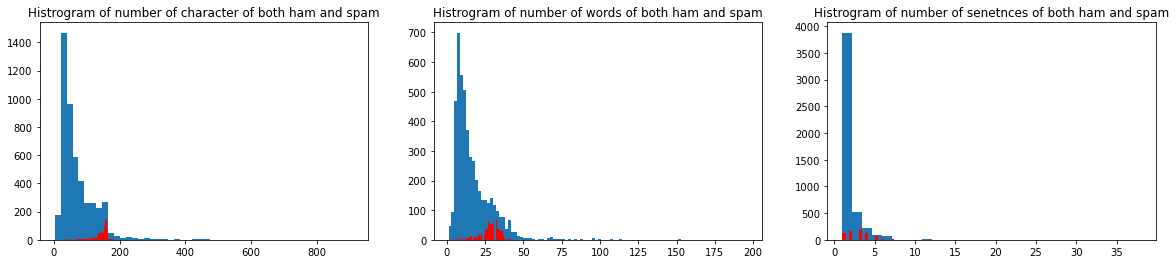

In [1422]:
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(20,4))

ax1.hist(sms_raw[sms_raw['type'] == 0]['num_characters'], bins=50);
ax1.hist(sms_raw[sms_raw['type'] == 1]['num_characters'], bins=50, color='red');
ax1.set(title="Histrogram of number of character of both ham and spam");

ax2.hist(sms_raw[sms_raw['type'] == 0]['num_words'], bins=100);
ax2.hist(sms_raw[sms_raw['type'] == 1]['num_words'], bins=50, color='red');
ax2.set(title="Histrogram of number of words of both ham and spam");

ax3.hist(sms_raw[sms_raw['type'] == 0]['num_sentences'], bins=30);
ax3.hist(sms_raw[sms_raw['type'] == 1]['num_sentences'], bins=20, color='red');
ax3.set(title="Histrogram of number of senetnces of both ham and spam");

### Data preprocessing
* Lower case
* Tokenization
* Remove special characters
* Remove stop words and punctuations
* stemming (limiting the same type of word such as dance, dencing, danced converted to single word word dance)

In [1423]:
# load stopwords and punctuations
import string 
import nltk

#download stopwords and punctuations
nltk.download('stopwords')
nltk.download('punkt')

#store them in variables
stopwords = nltk.corpus.stopwords.words('english')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pappu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pappu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1424]:
print(stopwords[0:10])
print(punctuations)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [1425]:
# stemming the word
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

# create a function for text preprocessing
def text_transform(text):
    text = "".join([char.lower() for char in text if char not in punctuations
        and not char.isdigit() and char not in '?£:!/;']) #convert lowercase and remove punction, character and numbers
    tokenize = nltk.tokenize.word_tokenize(text)
    remove_stopwords = [word for word in tokenize if word not in stopwords]
    word_stemming = [ps.stem(word) for word in remove_stopwords]
    return word_stemming

In [1426]:
text_transform("'Darren was saying ..... dat if u meeting da ge den we dun meet 4 dinner. Cos later u leave xy will feel awkward. Den u meet him 4 lunch lor.")

['darren',
 'say',
 'dat',
 'u',
 'meet',
 'da',
 'ge',
 'den',
 'dun',
 'meet',
 'dinner',
 'co',
 'later',
 'u',
 'leav',
 'xy',
 'feel',
 'awkward',
 'den',
 'u',
 'meet',
 'lunch',
 'lor']

In [1427]:
sms_raw['text'][16]

'Darren was saying dat if u meeting da ge den we dun meet 4 dinner. Cos later u leave xy will feel awkward. Den u meet him 4 lunch lor.'

In [1428]:
sms_raw['transformed_text'] = sms_raw['text'].apply(text_transform)

In [1429]:
sms_raw.head()

,type,text,num_characters,num_words,num_sentences,transformed_text
0,0,Hope you are having a good week. Just checking in,49,11,2,"[hope, good, week, check]"
1,0,K..give back my thanks.,23,7,1,"[kgive, back, thank]"
2,0,Am also doing in cbe only. But have to pay.,43,12,2,"[also, cbe, pay]"
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,23,3,"[complimentari, star, ibiza, holiday, cash, ne..."
4,1,okmail: Dear Dave this is your final notice to...,161,32,3,"[okmail, dear, dave, final, notic, collect, te..."


# Visualizing text data – word clouds

In [1430]:
sms_raw['transformed_text'] = sms_raw['transformed_text'].apply(lambda elt: str(int(elt)) if isinstance(elt, float) else str(elt))

In [1431]:
sms_raw['transformed_text']

0                       ['hope', 'good', 'week', 'check']
1                              ['kgive', 'back', 'thank']
2                                  ['also', 'cbe', 'pay']
3       ['complimentari', 'star', 'ibiza', 'holiday', ...
4       ['okmail', 'dear', 'dave', 'final', 'notic', '...
                              ...                        
5554    ['great', 'role', 'model', 'give', 'much', 're...
5555    ['awesom', 'rememb', 'last', 'time', 'got', 's...
5556    ['dont', 'prize', 'go', 'anoth', 'custom', 'tc...
5557    ['sm', 'ac', 'jsco', 'energi', 'high', 'u', 'm...
5558                    ['shall', 'call', 'dear', 'food']
Name: transformed_text, Length: 5559, dtype: object

In [1432]:
print(pd.api.types.infer_dtype(sms_raw['transformed_text']))

string


In [1433]:
# load wordcloud library 
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [1434]:
spam_wc = wc.generate(sms_raw[sms_raw['type'] == 1]['transformed_text'].str.cat(sep=" "))

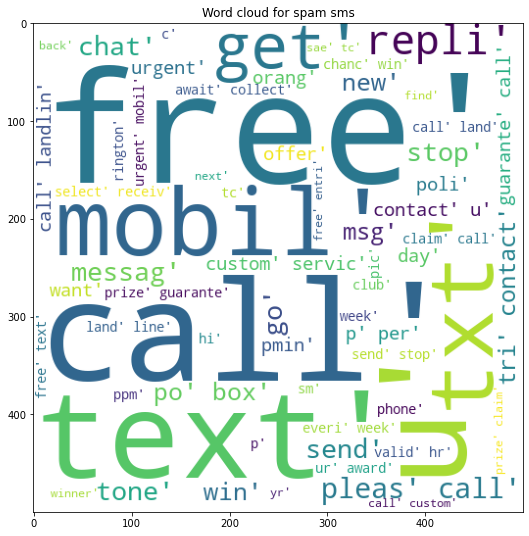

In [1435]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(spam_wc);
ax.set(title="Word cloud for spam sms");

In [1436]:
ham_wc = wc.generate(sms_raw[sms_raw['type'] == 0]['transformed_text'].str.cat(sep=" "))

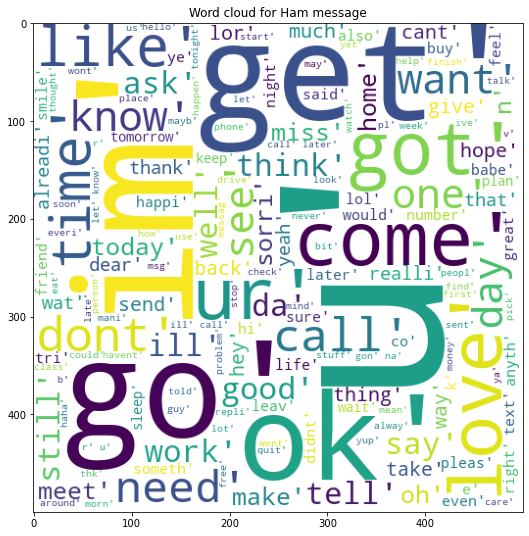

In [1437]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(ham_wc)
ax.set(title="Word cloud for Ham message");

In [1438]:
# Show the top 30 words in spam
spam_corpus = []
for sms in sms_raw[sms_raw['type'] == 1]['transformed_text'].tolist():
    for word in sms.split():
        spam_corpus.append(word)

In [1439]:
len(spam_corpus)

10680

In [1440]:
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(10))

,0,1
0,"'call',",318
1,"'free',",168
2,"'txt',",159
3,"'text',",133
4,"'u',",131
5,"'mobil',",127
6,"'ur',",124
7,"'claim',",112
8,"'repli',",105
9,"'stop',",94


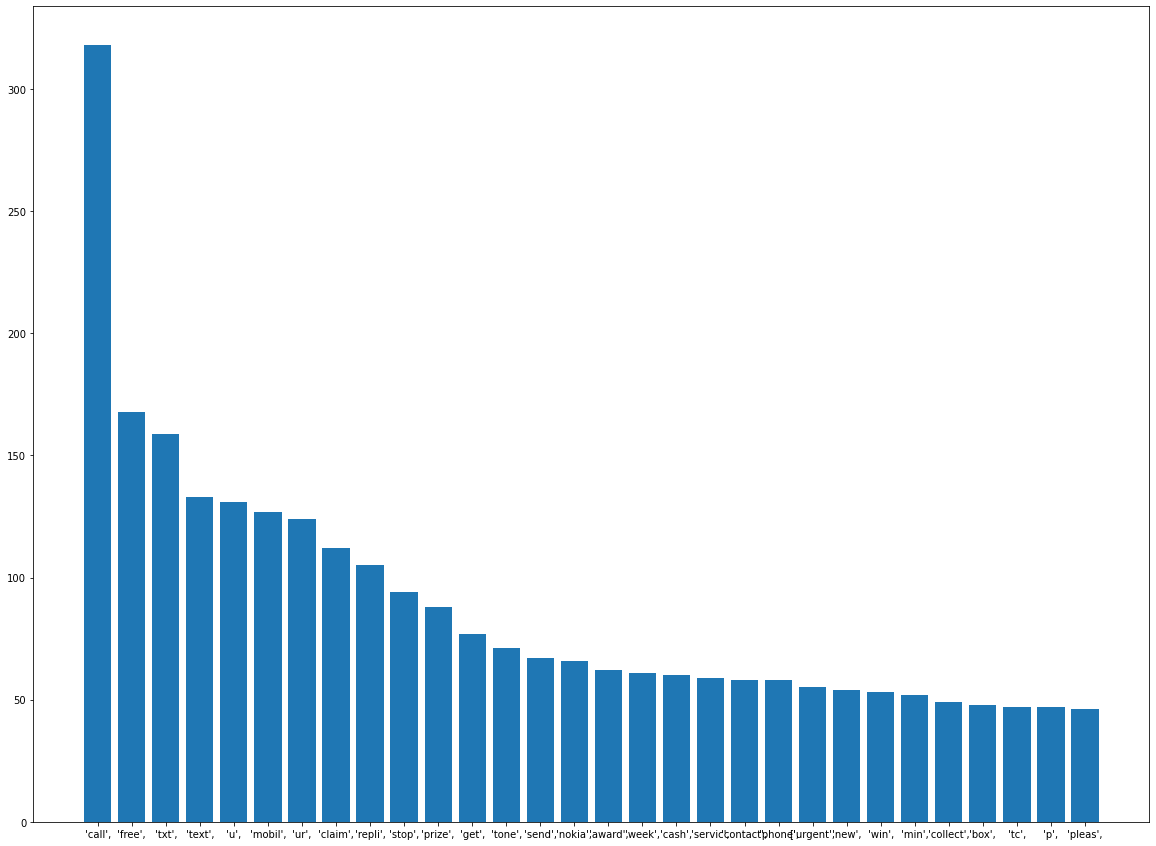

In [1441]:
fig, ax = plt.subplots(figsize=(20,15))
ax.bar(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1]);

In [1442]:
# Show the top 30 words in ham sms
ham_corpus = []
for sms in sms_raw[sms_raw['type']==0]['transformed_text'].tolist():
    for word in sms.split():
        ham_corpus.append(word)

In [1443]:
len(ham_corpus)

38836

In [1444]:
pd.DataFrame(Counter(ham_corpus).most_common(10))

,0,1
0,"'u',",946
1,"'go',",374
2,"'im',",317
3,"'get',",308
4,"'ur',",237
5,"'come',",228
6,"'call',",221
7,"'ill',",209
8,"'like',",205
9,"'dont',",199


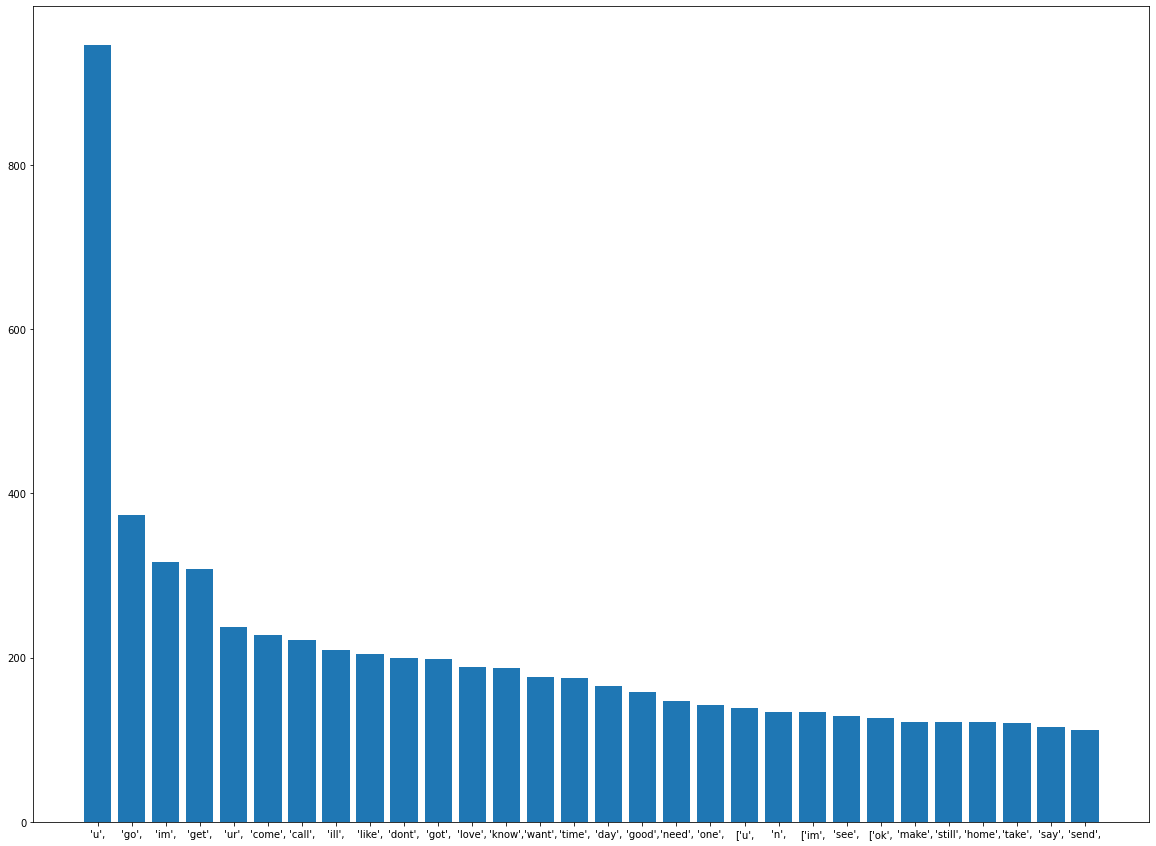

In [1445]:
fig, ax = plt.subplots(figsize=(20,15))
ax.bar(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1]);

### Build the model

In [1446]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [1447]:
X = cv.fit_transform(sms_raw['transformed_text']).toarray()

In [1448]:
X.shape

(5559, 7098)

In [1451]:
y = sms_raw['type'].values

In [1452]:
y

array([0, 0, 0, ..., 1, 1, 0])

In [1453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [1454]:
# Fit the model

In [1455]:
gnb = GaussianNB()
mbn = MultinomialNB()
bnb = BernoulliNB()

In [1456]:
# Prediction using Gaussian Naive Bayes
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
y_pred1

array([1, 0, 0, ..., 0, 1, 1])

In [1457]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))
print("Precision Score:\n", precision_score(y_test, y_pred1))

Accuracy Score:
 0.8669064748201439
Confusion Matrix:
 [[827 129]
 [ 19 137]]
Precision Score:
 0.5150375939849624


In [1458]:
# Prediction using Multinomial Naive Bayes 
mbn.fit(X_train, y_train)
y_pred2 = mbn.predict(X_test)
y_pred2

array([1, 0, 1, ..., 0, 0, 0])

In [1459]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred2))
print("Precision Score:\n", precision_score(y_test, y_pred2))

Accuracy Score:
 0.9703237410071942
Confusion Matrix:
 [[933  23]
 [ 10 146]]
Precision Score:
 0.863905325443787


In [1460]:
# Prediction using Bernoulli Naive Bayes
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
y_pred3

array([1, 0, 0, ..., 0, 0, 0])

In [1461]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred3))
print("Precision Score:\n", precision_score(y_test, y_pred3))

Accuracy Score:
 0.9676258992805755
Confusion Matrix:
 [[949   7]
 [ 29 127]]
Precision Score:
 0.9477611940298507


### Predict with other machine learning classifiers

In [1486]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn. naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [1492]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(C=1, penalty='l1', solver='liblinear')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators = 50, random_state=2)

In [1493]:
clfs = {
    'SVC': svc,
    'KN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'XGB': xgb
}

In [1494]:
def train_classifier(clf, X_train,y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [1484]:
train_classifier(svc,X_train,y_train, X_test, y_test)

(0.9739208633093526, 0.9774436090225563)

In [1495]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    print("For ", name)
    print("Accuracy - ", current_accuracy)
    print("Precision - ", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9739208633093526
Precision -  0.9774436090225563
For  KN
Accuracy -  0.9118705035971223
Precision -  1.0
For  NB
Accuracy -  0.9613309352517986
Precision -  0.9829059829059829
For  DT
Accuracy -  0.9406474820143885
Precision -  0.875
For  LR
Accuracy -  0.9523381294964028
Precision -  0.9401709401709402
For  RF
Accuracy -  0.9721223021582733
Precision -  1.0
For  AdaBoost
Accuracy -  0.9622302158273381
Precision -  0.9253731343283582
For  BgC
Accuracy -  0.9694244604316546
Precision -  0.9178082191780822
For  ETC
Accuracy -  0.9757194244604317
Precision -  0.9849624060150376
For  GBDT
Accuracy -  0.954136690647482
Precision -  0.9906542056074766
For  XGB
Accuracy -  0.9712230215827338
Precision -  0.9920634920634921


In [1500]:
performance_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy': accuracy_scores, 'Precision': precision_scores}).sort_values('Precision', ascending=False)

In [1501]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.911871,1.000000
5,RF,0.972122,1.000000
10,XGB,0.971223,0.992063
9,GBDT,0.954137,0.990654
8,ETC,0.975719,0.984962
2,NB,0.961331,0.982906
0,SVC,0.973921,0.977444
4,LR,0.952338,0.940171
6,AdaBoost,0.962230,0.925373
7,BgC,0.969424,0.917808


#### Improve the model performance 

In [1503]:
# Vectorize using TfidfVectorizer with max_features parameter of 3000
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)

In [1504]:
X = tfidf.fit_transform(sms_raw['transformed_text']).toarray()

In [1505]:
y = sms_raw['type'].values 

In [1506]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [1507]:
# Prediction using Gaussian Naive Bayes
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
y_pred1

array([1, 0, 0, ..., 0, 1, 1])

In [1508]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))
print("Precision Score:\n", precision_score(y_test, y_pred1))

Accuracy Score:
 0.8597122302158273
Confusion Matrix:
 [[822 134]
 [ 22 134]]
Precision Score:
 0.5


In [1509]:
# Prediction using Multinomial Naive Bayes 
mbn.fit(X_train, y_train)
y_pred2 = mbn.predict(X_test)
y_pred2

array([1, 0, 0, ..., 0, 0, 0])

In [1510]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred2))
print("Precision Score:\n", precision_score(y_test, y_pred2))

Accuracy Score:
 0.966726618705036
Confusion Matrix:
 [[953   3]
 [ 34 122]]
Precision Score:
 0.976


In [1511]:
# Prediction using Bernoulli Naive Bayes
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
y_pred3

array([1, 0, 0, ..., 0, 0, 0])

In [1512]:
print("Accuracy Score:\n", accuracy_score(y_test, y_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred3))
print("Precision Score:\n", precision_score(y_test, y_pred3))

Accuracy Score:
 0.9757194244604317
Confusion Matrix:
 [[951   5]
 [ 22 134]]
Precision Score:
 0.9640287769784173


#### The Multinomial Naive Bayes classifier provide the most accurate precession score when we vectorize using TfidfVectorizer. We we consider the Multinomial Naive Bayes classifier for this dataset. 

##### Cleaning such as punctuations, stopwords and other character etc.

In [1472]:
# load stopwords and punctuations
import string 
import nltk

#download stopwords and punctuations
nltk.download('stopwords')
nltk.download('punkt')

#store them in variables
stopwords = nltk.corpus.stopwords.words('english')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pappu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pappu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1473]:
print(stopwords[0:10])
print(punctuations)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [1474]:
# Pre-process sms content
def pre_process(sms):
    lowercase = "".join([char.lower() for char in sms if char not in punctuations
                         and not char.isdigit() and char not in '?£:!/;']) #convert lowercase and remove punction, character and numbers
    #remove_punct = "".join([char for char in sms if char not in punctuations]) 
    #lowercase = "".join([num for num in sms if not num.isdigit()])
    tokenize = nltk.tokenize.word_tokenize(lowercase) #Seperate the sentencs in words, this called tokenization
    remove_stopwords = [word for word in tokenize if word not in stopwords]
    return remove_stopwords

In [1475]:
#create a new column in our dataset and store processed data
sms_raw['processed'] = sms_raw['text'].apply(lambda x:pre_process(x))
sms_raw.head()

,type,text,num_characters,num_words,num_sentences,transformed_text,processed
0,0,Hope you are having a good week. Just checking in,49,11,2,"['hope', 'good', 'week', 'check']","[hope, good, week, checking]"
1,0,K..give back my thanks.,23,7,1,"['kgive', 'back', 'thank']","[kgive, back, thanks]"
2,0,Am also doing in cbe only. But have to pay.,43,12,2,"['also', 'cbe', 'pay']","[also, cbe, pay]"
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,23,3,"['complimentari', 'star', 'ibiza', 'holiday', ...","[complimentary, star, ibiza, holiday, cash, ne..."
4,1,okmail: Dear Dave this is your final notice to...,161,32,3,"['okmail', 'dear', 'dave', 'final', 'notic', '...","[okmail, dear, dave, final, notice, collect, t..."


In [1476]:
tokenize.info()

NameError: name 'tokenize' is not defined

In [ ]:
lst1 = []

def lst_square(lst):
    for i in lst:
        lst1.append(i*i)
    return lst1    

In [ ]:
lst_square([1,2,3,4,5,6,7])

In [ ]:
lst = [1,2,3,4,5,6,7]

In [ ]:
lst1 = [i*i for i in lst if i%2 != 0]

In [ ]:
lst1

In [ ]:
def addition(a,b):
    return a+b

In [ ]:
addition(4,5)

In [ ]:
addition = lambda a,b:a+b

In [ ]:
addition(12, 14)

In [ ]:
def even(num):
    if(num%2 == 0):
        return True

In [ ]:
even(10)

In [ ]:
even = lambda a:a%2==0

In [ ]:
even(10)